In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import xarray as xr
from pathlib import Path
from matplotlib import pyplot as plt
from time import perf_counter
from torchinfo import summary

In [2]:
ds = xr.load_dataset(Path.home() / 'research_data/GLP/synthetic_data/init_ds.nc')

In [3]:
class OutputScaler:
    def __init__(self, y):
        self.means = []
        self.stds = []
        self.num_features = y.shape[-1]
        for i in range(self.num_features):
            self.means.append(y[..., i].mean())
            self.stds.append(y[..., i].std())
            
    def transform(self, y_vals):
        self.y_scaled = y_vals.copy()
        for i in range(self.num_features):
            self.y_scaled[..., i] = (self.y_scaled[..., i] - self.means[i])/self.stds[i]
        return self.y_scaled
    
    def untransform(self, y_vals):
        self.y_unscaled = y_vals.copy()
        for i in range(self.num_features):
            self.y_unscaled[..., i] = self.y_unscaled[..., i]*self.stds[i] + self.means[i]
        return self.y_unscaled

In [4]:
def angle_categorizer(angle, num_categories, diagonal=False):
    region_angle = np.pi / num_categories
    comp_angles = angle / region_angle
    if diagonal:
        comp_angles += 1/2
        comp_angles = comp_angles.astype(int) % num_categories
    return comp_angles.astype(int)

In [5]:
num_classes = 2
ds_scaler = OutputScaler(np.stack([ds.maj_len.values, ds.min_len.values]).T)
# ds['target'] = (('p', 'axis'), ds_scaler.transform(np.stack([ds.maj_len.values, ds.min_len.values]).T))
ds['target'] = (('p'), angle_categorizer(ds.angle.values, num_classes, diagonal=True))

In [6]:
ds

<xarray.Dataset>
Dimensions:   (p: 10000, x: 128, y: 128)
Coordinates:
  * x         (x) int32 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * y         (y) int32 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Dimensions without coordinates: p
Data variables:
    ellipse   (p, x, y) float64 1.235e-05 1.3e-05 ... 4.358e-05 4.059e-05
    maj_len   (p) float64 27.24 25.74 26.25 32.18 ... 35.75 22.03 13.99 38.75
    min_len   (p) float64 17.63 12.59 16.9 7.789 ... 17.05 5.637 7.559 22.99
    angle     (p) float64 0.5636 2.522 0.1181 1.245 ... 0.04406 2.414 3.013
    center_x  (p) float64 67.13 80.68 52.94 70.23 ... 44.74 92.31 88.88 40.18
    center_y  (p) float64 106.1 67.43 45.49 106.9 ... 100.1 79.76 92.2 50.14
    target    (p) int64 0 0 0 1 0 1 0 1 1 1 0 0 0 ... 0 1 1 1 1 1 0 0 1 1 0 0 0

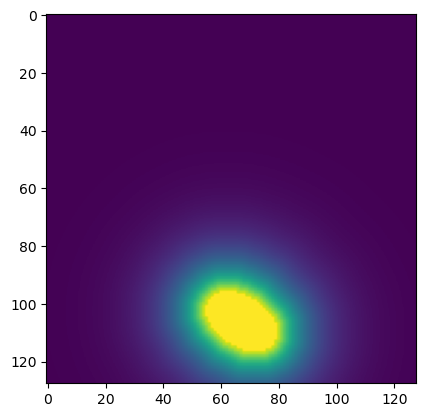

In [7]:
plt.imshow(ds.ellipse[0, :, :].values)

In [8]:
# Create custom dataset method
class SynthDataset(Dataset):
    def __init__(self, full_ds, start_idx=None, end_idx=None, transform=None, target_transform=None):
        self.full_ds = full_ds.isel(p=slice(start_idx, end_idx))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.full_ds.p.shape[0]

    def __getitem__(self, idx):
        image = torch.unsqueeze(torch.tensor(self.full_ds.ellipse[idx, :, :].values.astype(np.float32)), 0)
        label = torch.tensor(self.full_ds.target.isel(p=idx).values)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
cnn_out_channels = [4, 6, 8]
dense_neurons = 10
pooling_kernels = [2, 2]
final_dim = 128 // np.prod(pooling_kernels)

## CNN

In [60]:
cnn_train_ds = SynthDataset(ds, end_idx=8000)
cnn_val_ds = SynthDataset(ds, start_idx=8000)

batch_size = 32
cnn_train_dataloader = DataLoader(cnn_train_ds, num_workers=2, batch_size=batch_size, shuffle=True)
cnn_val_dataloader = DataLoader(cnn_val_ds, num_workers=2, batch_size=batch_size, shuffle=True)

In [61]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_encoding = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=cnn_out_channels[0], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pooling_kernels[0]),
            nn.Conv2d(in_channels=cnn_out_channels[0], out_channels=cnn_out_channels[1], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pooling_kernels[1]),
            nn.Conv2d(in_channels=cnn_out_channels[1], out_channels=cnn_out_channels[2], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.dense_stack = nn.Sequential(
            nn.Linear(final_dim*final_dim*cnn_out_channels[2], dense_neurons),
            nn.ReLU(),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        latent = self.conv_encoding(x)
        latent = self.flatten(latent)
        preds = self.dense_stack(latent)
        return preds

cnn_model = CNN().to(device)
print(cnn_model)

cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

CNN(
  (conv_encoding): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_stack): Sequential(
    (0): Linear(in_features=8192, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [62]:
summary(cnn_model, input_size=(batch_size, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 8, 32, 32]           --
│    └─Conv2d: 2-1                       [32, 4, 128, 128]         40
│    └─ReLU: 2-2                         [32, 4, 128, 128]         --
│    └─MaxPool2d: 2-3                    [32, 4, 64, 64]           --
│    └─Conv2d: 2-4                       [32, 6, 64, 64]           222
│    └─ReLU: 2-5                         [32, 6, 64, 64]           --
│    └─MaxPool2d: 2-6                    [32, 6, 32, 32]           --
│    └─Conv2d: 2-7                       [32, 8, 32, 32]           440
│    └─ReLU: 2-8                         [32, 8, 32, 32]           --
├─Flatten: 1-2                           [32, 8192]                --
├─Sequential: 1-3                        [32, 2]                   --
│    └─Linear: 2-9                       [32, 10]                  81,930
│    └─Re

In [63]:
def cnn_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def cnn_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [64]:
epochs = 20
print("Training CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    cnn_train(cnn_train_dataloader, cnn_model, cnn_loss_fn, cnn_optimizer)
    cnn_validate(cnn_val_dataloader, cnn_model, cnn_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training CNN 

Epoch 1
-------------------------------
loss: 0.702613  [   32/ 8000]
loss: 0.711580  [ 1056/ 8000]
loss: 0.695989  [ 2080/ 8000]
loss: 0.693938  [ 3104/ 8000]
loss: 0.693743  [ 4128/ 8000]
loss: 0.691672  [ 5152/ 8000]
loss: 0.690899  [ 6176/ 8000]
loss: 0.693222  [ 7200/ 8000]
Validation Error: 
 Accuracy: 50.7%, Avg loss: 0.692502
Epoch time: 1.85 seconds 

Epoch 2
-------------------------------
loss: 0.691270  [   32/ 8000]
loss: 0.697282  [ 1056/ 8000]
loss: 0.688640  [ 2080/ 8000]
loss: 0.690418  [ 3104/ 8000]
loss: 0.702045  [ 4128/ 8000]
loss: 0.687169  [ 5152/ 8000]
loss: 0.709058  [ 6176/ 8000]
loss: 0.683091  [ 7200/ 8000]
Validation Error: 
 Accuracy: 59.0%, Avg loss: 0.681485
Epoch time: 1.67 seconds 

Epoch 3
-------------------------------
loss: 0.702469  [   32/ 8000]
loss: 0.643429  [ 1056/ 8000]
loss: 0.671684  [ 2080/ 8000]
loss: 0.655216  [ 3104/ 8000]
loss: 0.658693  [ 4128/ 8000]
loss: 0.680242  [ 5152/ 8000]
loss: 0.666697  [ 6176/ 8000]
loss: 0.6

In [117]:
torch.save(cnn_model.state_dict(), './saved_models/synth_data_network_size_adjust/cnn.pt')

## Augmented CNN

In [16]:
aug_cnn_train_ds = SynthDataset(ds, end_idx=8000, transform=transforms.RandomRotation(15))
aug_cnn_val_ds = SynthDataset(ds, start_idx=8000)

batch_size = 32
aug_cnn_train_dataloader = DataLoader(aug_cnn_train_ds, num_workers=2, batch_size=batch_size, shuffle=True)
aug_cnn_val_dataloader = DataLoader(aug_cnn_val_ds, num_workers=2, batch_size=batch_size, shuffle=True)

In [83]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_encoding = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=cnn_out_channels[0], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pooling_kernels[0]),
            nn.Conv2d(in_channels=cnn_out_channels[0], out_channels=cnn_out_channels[1], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pooling_kernels[0]),
            nn.Conv2d(in_channels=cnn_out_channels[1], out_channels=cnn_out_channels[2], kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.dense_stack = nn.Sequential(
            nn.Linear(final_dim*final_dim*cnn_out_channels[2], dense_neurons),
            nn.ReLU(),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        latent = self.conv_encoding(x)
        latent = self.flatten(latent)
        preds = self.dense_stack(latent)
        return preds

aug_cnn_model = CNN().to(device)
print(aug_cnn_model)

aug_cnn_loss_fn = nn.CrossEntropyLoss()
aug_cnn_optimizer = torch.optim.Adam(aug_cnn_model.parameters(), lr=1e-4)

CNN(
  (conv_encoding): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_stack): Sequential(
    (0): Linear(in_features=8192, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [84]:
summary(aug_cnn_model, input_size=(batch_size, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 8, 32, 32]           --
│    └─Conv2d: 2-1                       [32, 4, 128, 128]         40
│    └─ReLU: 2-2                         [32, 4, 128, 128]         --
│    └─MaxPool2d: 2-3                    [32, 4, 64, 64]           --
│    └─Conv2d: 2-4                       [32, 6, 64, 64]           222
│    └─ReLU: 2-5                         [32, 6, 64, 64]           --
│    └─MaxPool2d: 2-6                    [32, 6, 32, 32]           --
│    └─Conv2d: 2-7                       [32, 8, 32, 32]           440
│    └─ReLU: 2-8                         [32, 8, 32, 32]           --
├─Flatten: 1-2                           [32, 8192]                --
├─Sequential: 1-3                        [32, 2]                   --
│    └─Linear: 2-9                       [32, 10]                  81,930
│    └─Re

In [85]:
def aug_cnn_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def aug_cnn_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [86]:
epochs = 20
print("Training Augmented CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    aug_cnn_train(aug_cnn_train_dataloader, aug_cnn_model, aug_cnn_loss_fn, aug_cnn_optimizer)
    aug_cnn_validate(aug_cnn_val_dataloader, aug_cnn_model, aug_cnn_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training Augmented CNN 

Epoch 1
-------------------------------
loss: 0.738449  [   32/ 8000]
loss: 0.695503  [ 1056/ 8000]
loss: 0.681034  [ 2080/ 8000]
loss: 0.693035  [ 3104/ 8000]
loss: 0.688681  [ 4128/ 8000]
loss: 0.705906  [ 5152/ 8000]
loss: 0.683573  [ 6176/ 8000]
loss: 0.692916  [ 7200/ 8000]
Validation Error: 
 Accuracy: 52.6%, Avg loss: 0.692933
Epoch time: 3.22 seconds 

Epoch 2
-------------------------------
loss: 0.692578  [   32/ 8000]
loss: 0.692860  [ 1056/ 8000]
loss: 0.683403  [ 2080/ 8000]
loss: 0.694254  [ 3104/ 8000]
loss: 0.692824  [ 4128/ 8000]
loss: 0.691987  [ 5152/ 8000]
loss: 0.697165  [ 6176/ 8000]
loss: 0.684546  [ 7200/ 8000]
Validation Error: 
 Accuracy: 56.4%, Avg loss: 0.691342
Epoch time: 2.95 seconds 

Epoch 3
-------------------------------
loss: 0.690370  [   32/ 8000]
loss: 0.678872  [ 1056/ 8000]
loss: 0.696128  [ 2080/ 8000]
loss: 0.677931  [ 3104/ 8000]
loss: 0.710887  [ 4128/ 8000]
loss: 0.670132  [ 5152/ 8000]
loss: 0.686751  [ 6176/ 8000]

In [116]:
torch.save(aug_cnn_model.state_dict(), './saved_models/synth_data_network_size_adjust/aug_cnn.pt')

## GLP CNN

In [87]:
class glp_transform(nn.Module):
    def __init__(self, num_angles=None, angle_inc=None):
        super().__init__()
        if (num_angles is None) and (angle_inc is None):
            raise ValueError('Need either num_angles or angle_inc to be defined')
        if num_angles is None:
            self.num_angles = 360 / angle_inc
            self.angle_inc = angle_inc
        else:
            self.angle_inc = 360 / num_angles
            self.num_angles = num_angles
        
    def __call__(self, image):
        temp_list = [transforms.functional.rotate(image, self.angle_inc*i) for i in range(int(self.num_angles))]
        return torch.stack(temp_list, dim=-1)

In [88]:
angle_inc = 30
num_angles = 360/angle_inc

glp_train_ds = SynthDataset(ds, end_idx=8000, transform = glp_transform(angle_inc=angle_inc))
glp_val_ds = SynthDataset(ds, start_idx=8000, transform = glp_transform(angle_inc=angle_inc))

batch_size = 32
glp_train_dataloader = DataLoader(glp_train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
glp_val_dataloader = DataLoader(glp_val_ds, batch_size=batch_size, num_workers=4, shuffle=True)

In [89]:
# Define model
class glp_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.full_stack = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=cnn_out_channels[0], kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(4, 4, 1)),
            nn.Conv3d(in_channels=cnn_out_channels[0], out_channels=cnn_out_channels[1], kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(4, 4, 1)),
            nn.Conv3d(in_channels=cnn_out_channels[1], out_channels=cnn_out_channels[2], kernel_size=(3, 3, 1), padding=(1, 1, 0), padding_mode='reflect'),
            nn.ReLU(),
        )
        self.glp_step = nn.Sequential(
            nn.MaxPool3d(kernel_size=(1, 1, 2)),
        )
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Sequential(
            nn.Linear(8*8*cnn_out_channels[2]*int(num_angles/2), dense_neurons),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        full_latent = self.full_stack(x)
        glp_latent = self.glp_step(full_latent)
        latent = self.flatten(glp_latent)
        latent = self.dense_1(latent)
        preds = self.classifier(latent)
        return preds, full_latent, glp_latent, latent

glp_model = glp_CNN().to(device)
print(glp_model)

glp_loss_fn = nn.CrossEntropyLoss()
glp_optimizer = torch.optim.Adam(glp_model.parameters(), lr=1e-4)

glp_CNN(
  (full_stack): Sequential(
    (0): Conv3d(1, 4, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(4, 4, 1), stride=(4, 4, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(4, 6, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(4, 4, 1), stride=(4, 4, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(6, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), padding_mode=reflect)
    (7): ReLU()
  )
  (glp_step): Sequential(
    (0): MaxPool3d(kernel_size=(1, 1, 2), stride=(1, 1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_1): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)


In [90]:
summary(glp_model, input_size=(batch_size, 1, 128, 128, int(num_angles)))

Layer (type:depth-idx)                   Output Shape              Param #
glp_CNN                                  [32, 2]                   --
├─Sequential: 1-1                        [32, 8, 8, 8, 12]         --
│    └─Conv3d: 2-1                       [32, 4, 128, 128, 12]     40
│    └─ReLU: 2-2                         [32, 4, 128, 128, 12]     --
│    └─MaxPool3d: 2-3                    [32, 4, 32, 32, 12]       --
│    └─Conv3d: 2-4                       [32, 6, 32, 32, 12]       222
│    └─ReLU: 2-5                         [32, 6, 32, 32, 12]       --
│    └─MaxPool3d: 2-6                    [32, 6, 8, 8, 12]         --
│    └─Conv3d: 2-7                       [32, 8, 8, 8, 12]         440
│    └─ReLU: 2-8                         [32, 8, 8, 8, 12]         --
├─Sequential: 1-2                        [32, 8, 8, 8, 6]          --
│    └─MaxPool3d: 2-9                    [32, 8, 8, 8, 6]          --
├─Flatten: 1-3                           [32, 3072]                --
├─Sequential:

In [91]:
def glp_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred, _, _, _ = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def glp_validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, _, _, _, = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [92]:
epochs = 20
print("Training GLP CNN \n")
t_time_start = perf_counter()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start_time = perf_counter()
    glp_train(glp_train_dataloader, glp_model, glp_loss_fn, glp_optimizer)
    glp_validate(glp_val_dataloader, glp_model, glp_loss_fn)
    print(f"Epoch time: {perf_counter() - start_time:.2f} seconds \n")
t_time = perf_counter() - t_time_start
print(f"Done! Total training time: {t_time // 60:.0f} minutes, {t_time % 60:.2f} seconds, average epoch time: {t_time/epochs:.2f} seconds")

Training GLP CNN 

Epoch 1
-------------------------------
loss: 0.688949  [   32/ 8000]
loss: 0.689661  [ 1056/ 8000]
loss: 0.691852  [ 2080/ 8000]
loss: 0.693021  [ 3104/ 8000]
loss: 0.693084  [ 4128/ 8000]
loss: 0.693001  [ 5152/ 8000]
loss: 0.694175  [ 6176/ 8000]
loss: 0.690179  [ 7200/ 8000]
Validation Error: 
 Accuracy: 52.9%, Avg loss: 0.691594
Epoch time: 12.30 seconds 

Epoch 2
-------------------------------
loss: 0.696726  [   32/ 8000]
loss: 0.686880  [ 1056/ 8000]
loss: 0.690116  [ 2080/ 8000]
loss: 0.692487  [ 3104/ 8000]
loss: 0.685768  [ 4128/ 8000]
loss: 0.696893  [ 5152/ 8000]
loss: 0.670077  [ 6176/ 8000]
loss: 0.690426  [ 7200/ 8000]
Validation Error: 
 Accuracy: 60.1%, Avg loss: 0.683524
Epoch time: 12.00 seconds 

Epoch 3
-------------------------------
loss: 0.677158  [   32/ 8000]
loss: 0.680994  [ 1056/ 8000]
loss: 0.673239  [ 2080/ 8000]
loss: 0.648597  [ 3104/ 8000]
loss: 0.659368  [ 4128/ 8000]
loss: 0.614318  [ 5152/ 8000]
loss: 0.654703  [ 6176/ 8000]
los

In [115]:
torch.save(glp_model.state_dict(), './saved_models/synth_data_network_size_adjust/glp.pt')

## Latent Space Analysis

In [93]:
import phate
import scipy.ndimage as nd
rng = np.random.default_rng()

In [94]:
x = np.arange(0, 128)
y = np.arange(0, 128)[:, None]
maj_len = rng.uniform(10.0, 40.0)
min_len = rng.uniform(5.0, maj_len/1.5)
ang = 0 # rng.uniform(0, np.pi)
(x0, y0) = rng.uniform(20.0, 108, 2)
ellipse = (
    (((x - x0)*np.cos(ang) + (y - y0)*np.sin(ang)) / (maj_len/2))**2
    + (((x - x0)*np.sin(ang) - (y - y0)*np.cos(ang)) / (min_len/2))**2
    <= 1
)
test_ellipse = np.exp(-0.1*nd.distance_transform_edt(1 - ellipse))

In [95]:
# sample_ind = 9200
glp_preds = []
cnn_preds = []
aug_cnn_preds = []
full_latent = []
glp_latent = []
dense_latent = []
for i in range(360):
    test_sample = transforms.functional.rotate(torch.unsqueeze(torch.unsqueeze(torch.tensor(test_ellipse.astype(np.float32)), 0), 0), i)
    test_tf = glp_transform(angle_inc=angle_inc)
    with torch.no_grad():
        preds, f_lat, g_lat, dense_lat = glp_model(test_tf(test_sample.to(device)))
        cnn_preds_temp = cnn_model(test_sample.to(device))
        aug_cnn_preds_temp = aug_cnn_model(test_sample.to(device))
        cnn_preds.append(cnn_preds_temp.detach().cpu().numpy()[0])
        aug_cnn_preds.append(aug_cnn_preds_temp.detach().cpu().numpy()[0])
        glp_preds.append(preds.detach().cpu().numpy()[0])
        full_latent.append(f_lat.detach().cpu().numpy()[0])
        glp_latent.append(g_lat.detach().cpu().numpy()[0])
        dense_latent.append(dense_lat.detach().cpu().numpy()[0])
glp_preds = np.array(glp_preds)
cnn_preds = np.array(cnn_preds)
aug_cnn_preds = np.array(aug_cnn_preds)
full_latent = np.array(full_latent)
glp_latent = np.array(glp_latent)
dense_latent = np.array(dense_latent)

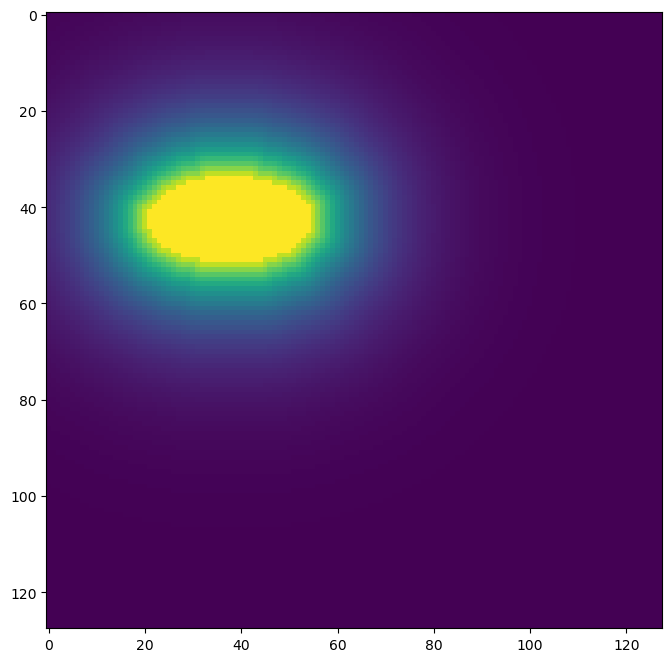

In [96]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(test_ellipse)

In [97]:
full_latent.shape

(360, 8, 8, 8, 12)

In [98]:
glp_latent.shape

(360, 8, 8, 8, 6)

In [99]:
dense_latent.shape

(360, 10)

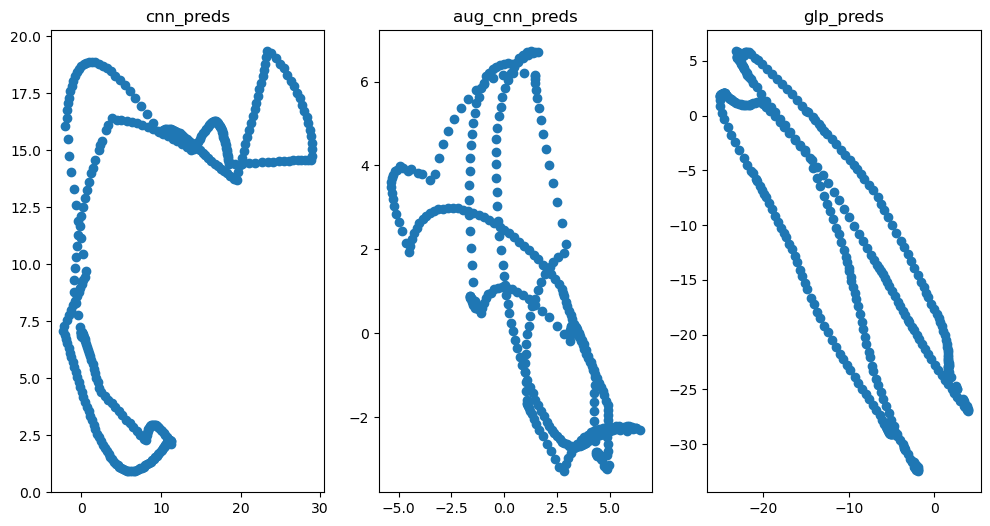

In [100]:
f, ax = plt.subplots(1, 3, figsize=(12, 6))
titles = ['cnn_preds', 'aug_cnn_preds', 'glp_preds']
for i, dat in enumerate([cnn_preds, aug_cnn_preds, glp_preds]):
    ax[i].scatter(dat[:, 0], dat[:, 1])
    ax[i].set_title(titles[i])

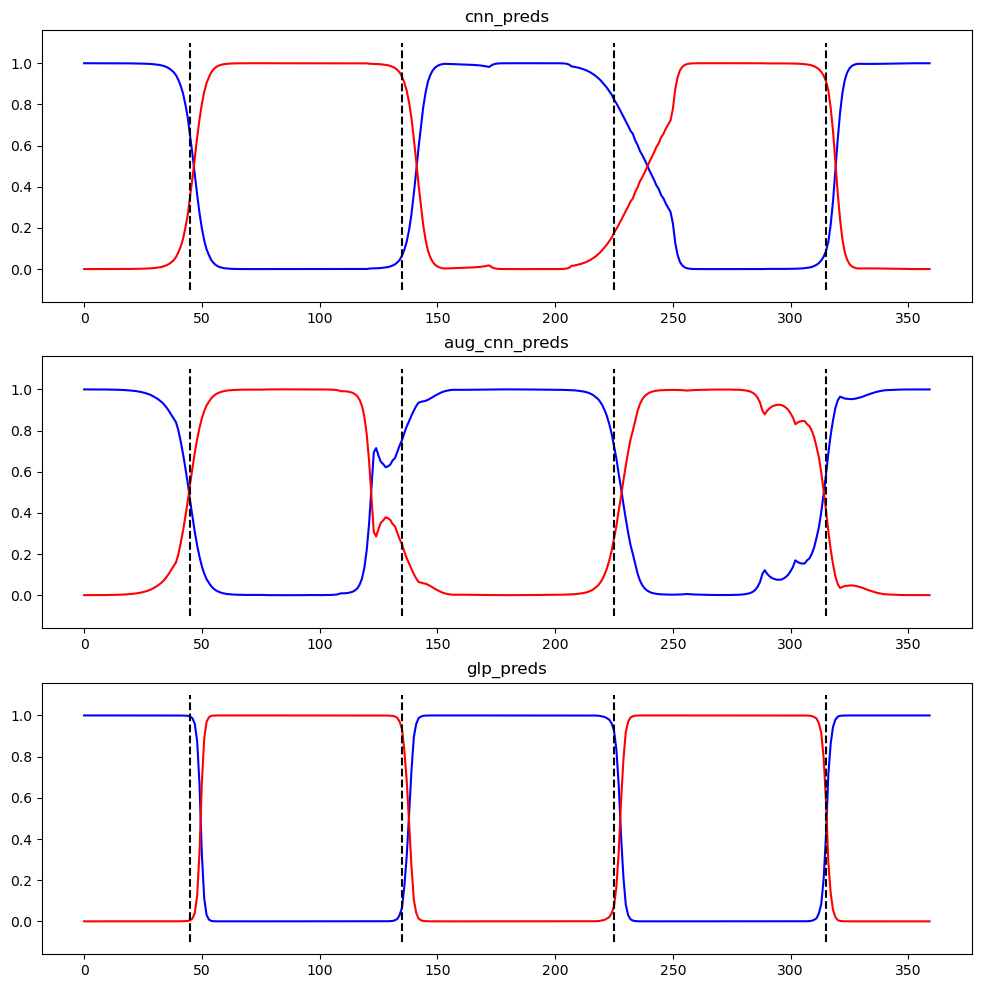

In [101]:
# Analyze transitions between classes
m = nn.Softmax(dim=1)
f, ax = plt.subplots(3, 1, figsize=(12, 12))
titles = ['cnn_preds', 'aug_cnn_preds', 'glp_preds']
for i, dat in enumerate([cnn_preds, aug_cnn_preds, glp_preds]):
    plot_dat = m(torch.Tensor(dat))
    ax[i].plot(plot_dat[:, 0], color='blue')
    ax[i].plot(plot_dat[:, 1], color='red')
    ax[i].set_title(titles[i])
    ax[i].vlines([45, 135, 225, 315], -0.1, 1.1, colors='black', linestyles='dashed')

In [102]:
flat_full_latent = full_latent.reshape(full_latent.shape[0], -1)
flat_glp_latent = glp_latent.reshape(glp_latent.shape[0], -1)

In [107]:
phate_full = phate.PHATE(n_jobs=-2)
phate_glp = phate.PHATE(n_jobs=-2)
phate_dense = phate.PHATE(n_jobs=-2)

full_2d = phate_full.fit_transform(flat_full_latent)
glp_2d = phate_glp.fit_transform(flat_glp_latent)
dense_2d = phate_dense.fit_transform(dense_latent)

Calculating PHATE...
  Running PHATE on 360 observations and 6144 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.04 seconds.
Calculated PHATE in 0.13 seconds.
Calculating PHATE...
  Running PHATE on 360 observations and 3072 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculat

Text(0.5, 1.0, 'Latent space after Dense Layer')

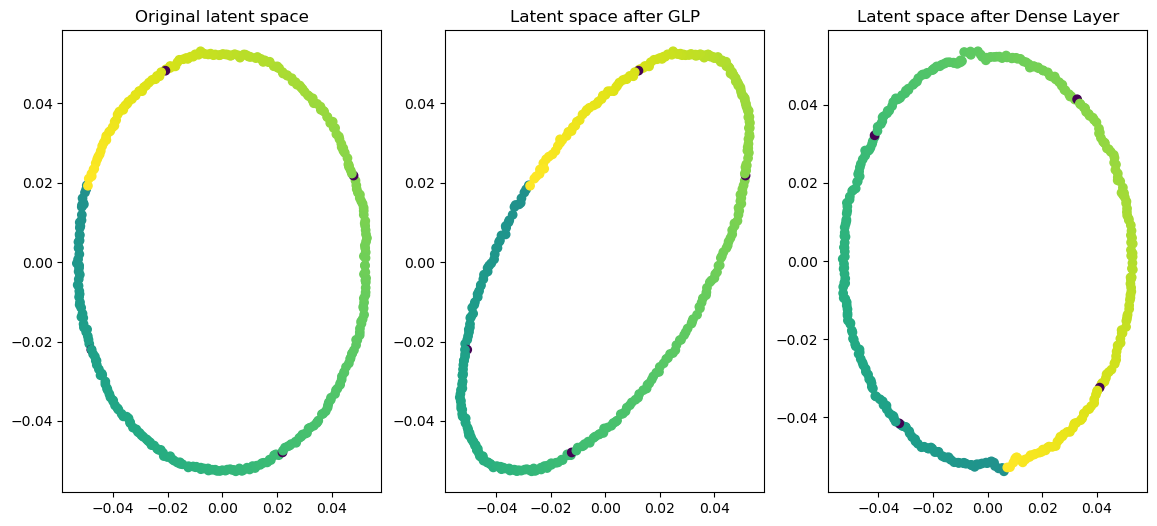

In [108]:
index_color = list(range(360))
for i in [45, 135, 225, 315]:
    index_color[i] = -360
F, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].scatter(full_2d[:, 0], full_2d[:, 1], c=index_color)
ax[0].set_title('Original latent space')
ax[1].scatter(glp_2d[:, 0], full_2d[:, 1], c=index_color)
ax[1].set_title('Latent space after GLP')
ax[2].scatter(dense_2d[:, 0], dense_2d[:, 1], c=index_color)
ax[2].set_title('Latent space after Dense Layer')

In [109]:
from ripser import ripser
from persim import plot_diagrams

In [110]:
full_lat_dgm = ripser(flat_full_latent)['dgms']
glp_lat_dgm = ripser(flat_glp_latent)['dgms']

/home/lverhoef/miniconda3/envs/glp-wsl/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/lverhoef/miniconda3/envs/glp-wsl/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


Text(0.5, 1.0, 'Latent space after GLP')

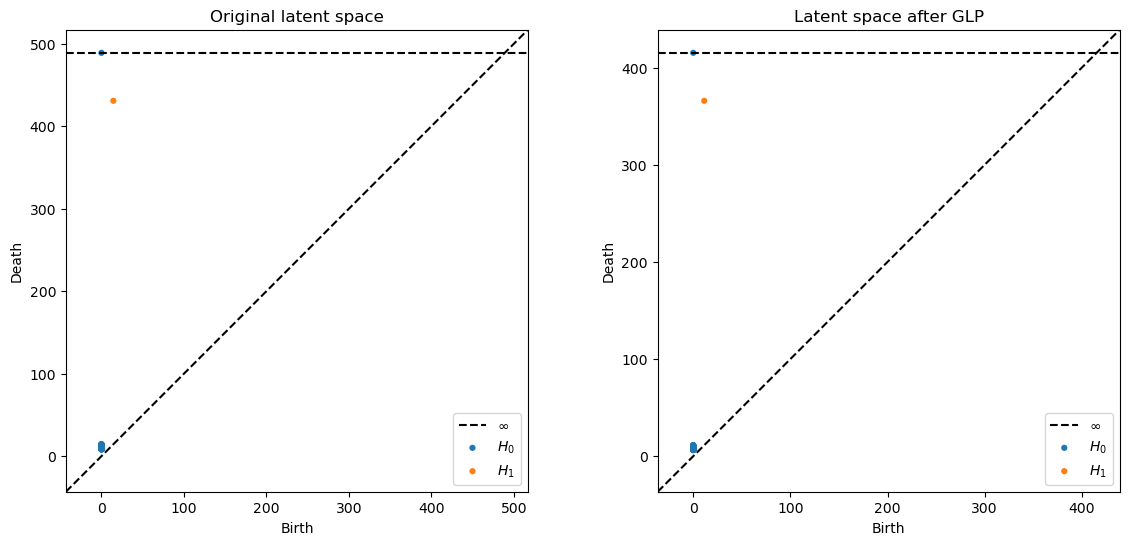

In [111]:
F, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_diagrams(full_lat_dgm, ax=ax[0])
ax[0].set_title('Original latent space')
plot_diagrams(glp_lat_dgm, ax=ax[1])
ax[1].set_title('Latent space after GLP')

In [112]:
full_lat_dgm[1]

array([[ 14.44884777, 430.72210693]])

In [113]:
glp_lat_dgm[1]

array([[ 11.29282665, 365.89620972]])

In [114]:
f_min_len = full_lat_dgm[1][-1][1]
g_min_len = glp_lat_dgm[1][-1][1]

f_max_len = 0
g_max_len = 0
for i in range(flat_full_latent.shape[0]):
    for j in range(i+1, flat_full_latent.shape[0]):
        f_cand = np.linalg.norm(flat_full_latent[i] - flat_full_latent[j])
        g_cand = np.linalg.norm(flat_glp_latent[i] - flat_glp_latent[j])
        if f_cand > f_max_len:
            f_max_len = f_cand
        if g_cand > g_max_len:
            g_max_len = g_cand
            
print(f'Full latent oval: {f_max_len:.3f} by {f_min_len:.3f}\nGLP latent oval: {g_max_len:.3f} by {g_min_len:.3f}')

Full latent oval: 446.025 by 430.722
GLP latent oval: 388.017 by 365.896
